In [1]:
import numpy as np
import qutip as qutip
import time as time

from matplotlib import pyplot as plt

import sys
import os
sys.path.append('../../utils')

from tomography import coherent_state_tomography as cst
from tomography import coherent_state_tomography_copy as cst2
from visualization import state_visualization as state_vis
from quantum_utils import quantum_optics_utils as qou

from mpl_toolkits.mplot3d.axes3d import Axes3D
from math_utils import statistics_utils as su

In [2]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [3]:
# Parameters
dim = 300
mesh_size = 0.25
max_x = 6
alphas, xs, ps = cst2.generate_complex_mesh(max_x, mesh_size)

number_of_noise_photons = 2

eta = 0.75
gain = 10
decoherence = 1

pure_state_output = (qutip.basis(dim, 0) + eta**(1/2)*qutip.basis(dim, 1)).unit()
pure_state_output_rho = pure_state_output * pure_state_output.dag()
vacuum_rho = qutip.basis(dim, 0) * qutip.basis(dim, 0).dag()
beam_splitter_output_rho = (1 + eta)/2 * pure_state_output_rho + (1 - eta)/2 * vacuum_rho
beam_splitter_output_matrix = np.array(beam_splitter_output_rho)
beam_splitter_output_matrix[0][1] = decoherence * beam_splitter_output_matrix[0][1]
beam_splitter_output_matrix[1][0] = decoherence * beam_splitter_output_matrix[1][0]
beam_splitter_output_rho = qutip.Qobj(beam_splitter_output_matrix)

<IPython.core.display.Javascript object>


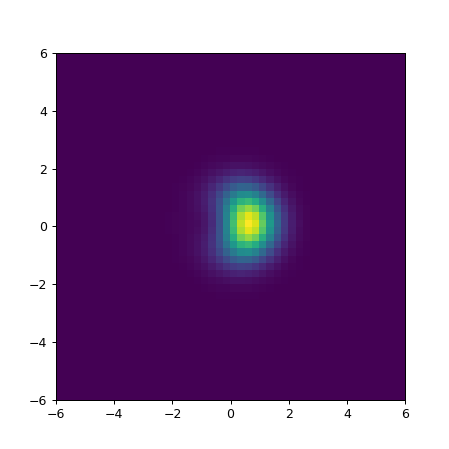

In [4]:
fig, ax = state_vis.plot_qfunc(beam_splitter_output_rho, xs, ps)

In [5]:
thermally_noisy_qfunc = cst2.evaluate_thermally_noisy_Q_function(beam_splitter_output_rho,
                                                                number_of_noise_photons,
                                                                xs,
                                                                ps)

<IPython.core.display.Javascript object>


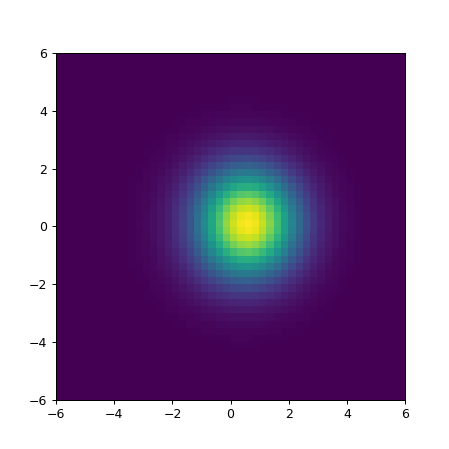

0.10053145982081067


In [6]:
fig, ax = state_vis.plot_image(thermally_noisy_qfunc, xs, ps)
print(np.max(thermally_noisy_qfunc))

In [7]:
samples = su.sample_2d_distribution(thermally_noisy_qfunc, 100000000, area_element=mesh_size**2) / mesh_size**2

<IPython.core.display.Javascript object>


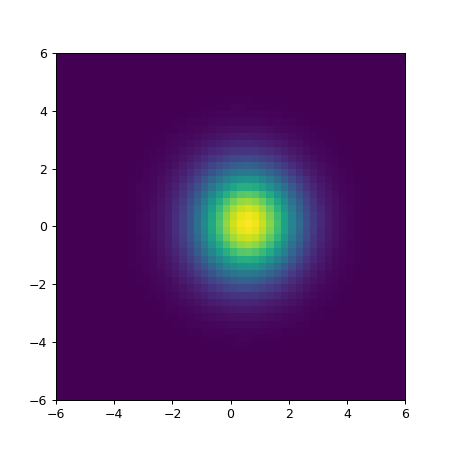

0.10043951266805926


In [8]:
fig, ax = state_vis.plot_image(samples, xs, ps)
print(np.max(samples))

In [9]:
noise_rho = qutip.thermal_dm(dim, number_of_noise_photons)
noise_qfunc = qutip.qfunc(noise_rho, xs, ps, g=2)
noise_samples = su.sample_2d_distribution(noise_qfunc, 100000000, area_element=mesh_size**2) / mesh_size**2

In [10]:
S = su.average_over_histogram(samples, alphas, mesh_size**2)
S_dag_S = su.average_over_histogram(samples, alphas*np.conj(alphas), mesh_size**2)
h_dag_h = su.average_over_histogram(noise_samples, alphas*np.conj(alphas), mesh_size**2)

In [11]:
sqrtG = (S_dag_S - h_dag_h)/np.abs(S)

In [582]:
print(S_dag_S - h_dag_h)

(0.37389274910271464+0j)


In [12]:
print(alphas.shape)
print(noise_qfunc.shape)
noise_samples = su.sample_2d_distribution_values(noise_qfunc, alphas, 10000000, area_element=mesh_size**2)

(49, 49)
(49, 49)


In [13]:
sampled_qfunc = su.evenly_histogram_2d_data(np.real(noise_samples), np.imag(noise_samples), xs, ps, mesh_size)

<IPython.core.display.Javascript object>


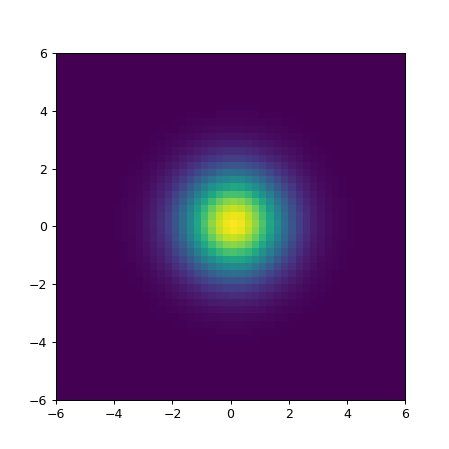

(<Figure size 500x500 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1a2041fd50>)

In [14]:
state_vis.plot_image(sampled_qfunc, xs, ps)

In [15]:
# Parameters
dim = 300
scaled_mesh_size = mesh_size / np.real(sqrtG)
max_x = 10
scaled_alphas, scaled_xs, scaled_ps = cst2.generate_complex_mesh(max_x, scaled_mesh_size)
scaled_xs = xs / np.real(sqrtG)
scaled_ps = ps / np.real(sqrtG)
scaled_alphas = alphas / np.real(sqrtG)
scaled_thermally_noisy_qfunc = thermally_noisy_qfunc * (np.abs(sqrtG))**2
scaled_noise_qfunc = noise_qfunc * (np.abs(sqrtG))**2

In [16]:
print(np.sum(scaled_noise_qfunc) * (np.abs(sqrtG)**2))

8.902285852671781


In [17]:
print(sqrtG)

(0.8636653706632815+0j)


<IPython.core.display.Javascript object>


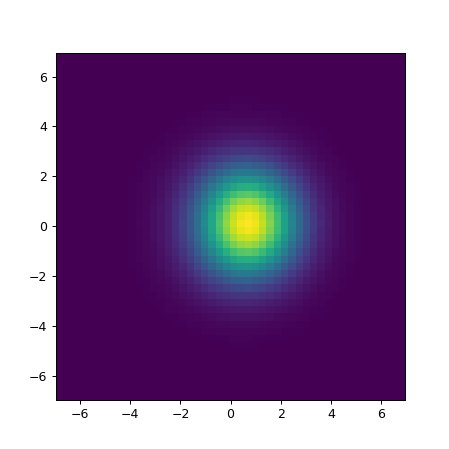

In [18]:
fig, ax = state_vis.plot_image(thermally_noisy_qfunc, scaled_xs, scaled_ps)

In [19]:
samples = su.sample_2d_distribution(scaled_thermally_noisy_qfunc, 100000000, area_element=scaled_mesh_size**2) / scaled_mesh_size**2
noise_samples = su.sample_2d_distribution(scaled_noise_qfunc, 100000000, area_element=scaled_mesh_size**2) / scaled_mesh_size**2

scaled_S = su.average_over_histogram(samples, scaled_alphas, scaled_mesh_size**2)
scaled_S_dag_S = su.average_over_histogram(samples, scaled_alphas*np.conj(scaled_alphas), scaled_mesh_size**2)
scaled_h_dag_h = su.average_over_histogram(noise_samples, scaled_alphas*np.conj(scaled_alphas), scaled_mesh_size**2)

scaled_sqrtG = (scaled_S_dag_S - scaled_h_dag_h)/np.abs(scaled_S)
print(scaled_sqrtG)
print(scaled_S)
print(scaled_S_dag_S)
print(scaled_S_dag_S - scaled_h_dag_h)

(0.9992844270936335+0j)
(0.5013579069576414-0.00014613897750706022j)
(4.522861510816005+0j)
(0.5009991701065459+0j)


In [20]:
ssamples = su.sample_2d_distribution_values(thermally_noisy_qfunc, alphas, 100000000, area_element=mesh_size**2) / sqrtG
snoise_samples = su.sample_2d_distribution_values(noise_qfunc, alphas, 100000000, area_element=mesh_size**2) / sqrtG

# ssamples = su.sample_2d_distribution_values(scaled_thermally_noisy_qfunc, scaled_alphas, 10000000, area_element=scaled_mesh_size**2) 
# snoise_samples = su.sample_2d_distribution_values(scaled_noise_qfunc, scaled_alphas, 10000000, area_element=scaled_mesh_size**2) 

a = np.mean(ssamples); hdag_h = np.mean(np.abs(snoise_samples)**2); 
hdag_2_h_2 = np.mean(np.abs(snoise_samples)**4) 
adag_a = np.mean(np.abs(ssamples)**2) - hdag_h
a_2 = np.mean(ssamples**2); 
adag_2_a = np.mean(np.conj(ssamples)*np.abs(ssamples)**2) - 2 * np.conj(a) * hdag_h
adag_2_a_2 = np.mean(np.abs(ssamples)**4) - 4*adag_a*hdag_h - hdag_2_h_2



In [21]:
print(adag_a)
print(a)

0.5022401167677808
(0.5017790046012597+0.0001236474259909103j)


<IPython.core.display.Javascript object>


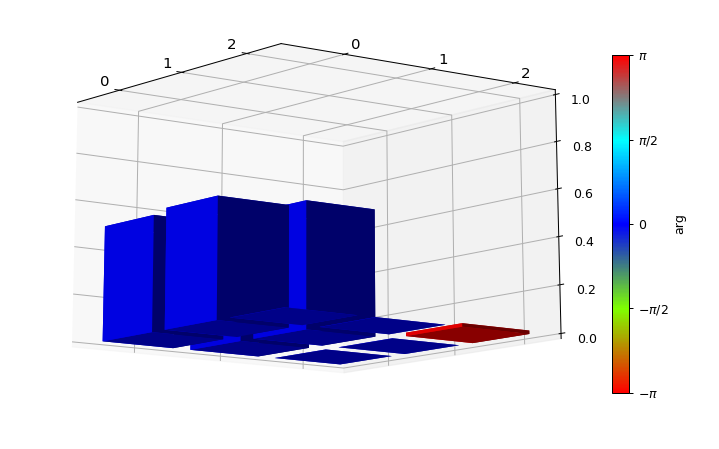

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 4.83620247e-01+0.j          5.01329537e-01-0.00058343j
  -5.53376717e-07+0.00035187j]
 [ 5.01329537e-01+0.00058343j  5.30519389e-01+0.j
   3.17821595e-04+0.00049998j]
 [-5.53376717e-07-0.00035187j  3.17821595e-04-0.00049998j
  -1.41396362e-02+0.j        ]]

In [22]:

rho_from_moments = np.zeros((3,3), dtype = complex)

rho_from_moments[0,0] = 1 - adag_a +  adag_2_a_2/2
rho_from_moments[0,1] = a - np.conj(adag_2_a)
rho_from_moments[0,2] = a_2/np.sqrt(2)

rho_from_moments[1,0] = np.conj(rho_from_moments[0,1])
rho_from_moments[1,1] = adag_a - adag_2_a_2
rho_from_moments[1,2] = np.conj(adag_2_a)/np.sqrt(2)


rho_from_moments[2,0] = np.conj(rho_from_moments[0,2])
rho_from_moments[2,1] = np.conj(rho_from_moments[1,2])
rho_from_moments[2,2] = adag_2_a_2/2

fig = plt.figure( figsize=(8,5) )
ax = Axes3D(fig, azim=-35, elev=35)
qutip.matrix_histogram_complex(rho_from_moments, fig=fig, ax=ax)
qutip.Qobj(rho_from_moments)

In [594]:
S = su.average_over_histogram(scaled_thermally_noisy_qfunc, scaled_alphas, scaled_mesh_size**2)
S_dag_S = su.average_over_histogram(scaled_thermally_noisy_qfunc, scaled_alphas*np.conj(scaled_alphas), scaled_mesh_size**2)
h_dag_h = su.average_over_histogram(scaled_noise_qfunc, scaled_alphas*np.conj(scaled_alphas), scaled_mesh_size**2)

In [23]:
# Do MLE Reconstruction of these thangs

noise_histogram = su.evenly_histogram_2d_data(np.real(snoise_samples),
                                              np.imag(snoise_samples),
                                              scaled_xs,
                                              scaled_ps,
                                              scaled_mesh_size)
data_histogram = su.evenly_histogram_2d_data(np.real(ssamples),
                                              np.imag(ssamples),
                                              scaled_xs,
                                              scaled_ps,
                                              scaled_mesh_size)

In [24]:
np.max(scaled_xs)

6.947135087044296

In [597]:
# Construct the ideal POVM for the noise reconstruction
scaled_max_x = np.max(scaled_xs)

# Define the range of dimensions
dim = 100

s = time.time()
scaled_ideal_povm, scaled_alphas2, scaled_xs2, scaled_ps2 = cst2.generate_coherent_state_POVM(scaled_max_x, 
                                                              scaled_mesh_size, 
                                                              dim,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 23.739372730255127 seconds


In [603]:
# Do the noise state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 100
s = time.time()
reconstructed_noise_state, noise_lls = \
    cst2.perform_coherent_state_MLE(
        scaled_ideal_povm,
        noise_histogram, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_noise_state,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')
# HERE

Time for MLE reconstruction for dim = 100: 178.78137278556824 s


<IPython.core.display.Javascript object>


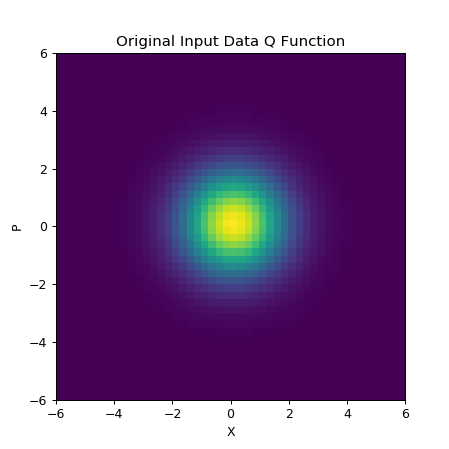

<IPython.core.display.Javascript object>


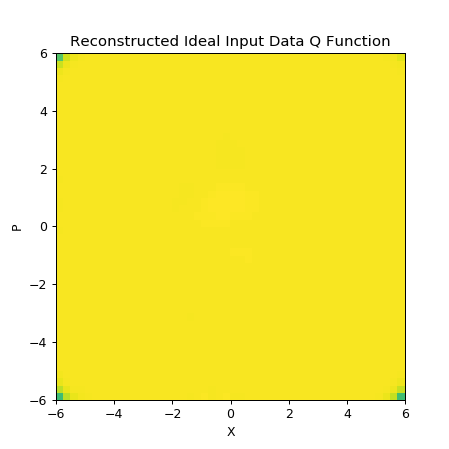

<IPython.core.display.Javascript object>


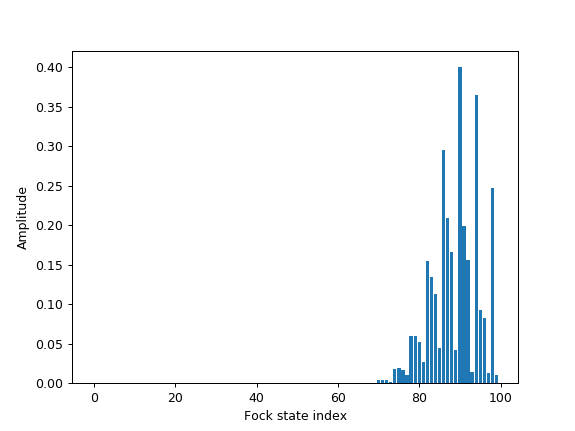

In [606]:
cst2.plot_coherent_state_tomography_Q_functions(noise_histogram,
                                               reconstructed_noise_state,
                                               scaled_xs,
                                               scaled_ps)

<IPython.core.display.Javascript object>


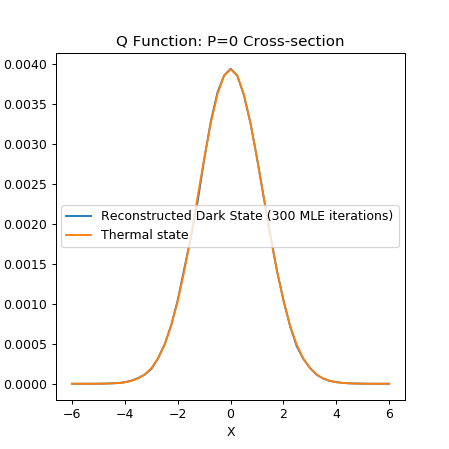

0.9999989162651244


In [36]:
# Fit the noise state to get the noise photons
number_of_noise_photons = 3.02
ideal_noise_state = qutip.thermal_dm(dim, number_of_noise_photons)
ideal_noisy_qfunc = qutip.qfunc(ideal_noise_state, scaled_xs, scaled_ps, g=2)
reconstructed_noisy_qfunc = noise_histogram#qutip.qfunc(reconstructed_noise_state, xs, ps, g=2)

fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(xs, reconstructed_noisy_qfunc[len(xs) // 4], label='Reconstructed Dark State (300 MLE iterations)')
ax.plot(xs, ideal_noisy_qfunc[len(xs) // 4], label='Thermal state')
ax.set_xlabel('X')
ax.set_ylabel('Q')
ax.legend()
ax.set_title('Q Function: P=0 Cross-section')
print(np.sum(ideal_noisy_qfunc)*scaled_mesh_size**2)

In [37]:
# Construct the noisy POVM for the signal state reconstruction
scaled_max_x = np.max(scaled_xs)

# Define the range of dimensions
dim = 100
high_dimensional_ideal_noise_state = qutip.thermal_dm(dim, number_of_noise_photons)

s = time.time()
scaled_noisy_povm, scaled_alphas3, scaled_xs3, scaled_ps3 = cst2.generate_coherent_state_POVM(scaled_max_x, 
                                                              scaled_mesh_size, 
                                                              dim,
                                                              noise_base = high_dimensional_ideal_noise_state,
                                                              cutoff=0)
e = time.time()
print('Constructing POVM took: ' + str(e - s) + str(' seconds'))

Constructing POVM took: 42.21311283111572 seconds


In [60]:
# Pending 10000 + 8000

# Do the signal state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 6000
s = time.time()
reconstructed_signal_state2, signal_lls = \
    cst2.perform_coherent_state_MLE(
        scaled_noisy_povm,
        data_histogram, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_signal_state,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 100: 5837.156448125839 s


In [61]:
# CP1

# Do the signal state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 6000
s = time.time()
reconstructed_signal_state3, signal_lls = \
    cst2.perform_coherent_state_MLE(
        scaled_noisy_povm,
        data_histogram, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_signal_state2,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 100: 5845.745312929153 s


In [62]:
# CP2

# Do the signal state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 6000
s = time.time()
reconstructed_signal_state4, signal_lls = \
    cst2.perform_coherent_state_MLE(
        scaled_noisy_povm,
        data_histogram, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_signal_state3,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 100: 5810.695149898529 s


In [67]:
# CP3

# Do the signal state MLE
# Perform ideal coherent state POVM MLE
number_of_mle_iterations = 6000
s = time.time()
reconstructed_signal_state7, signal_lls = \
    cst2.perform_coherent_state_MLE(
        scaled_noisy_povm,
        data_histogram, 
        number_of_mle_iterations,
        frequency_threshold=0,
        cutoff=0,
        rho0=reconstructed_signal_state6,
        identity_mixin=0)
e = time.time()
print('Time for MLE reconstruction for dim = ' + str(dim) + ': ' + str(e - s) + ' s')

Time for MLE reconstruction for dim = 100: 7184.92888712883 s


<IPython.core.display.Javascript object>


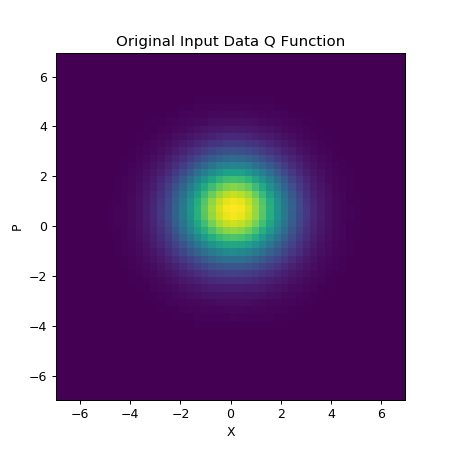

<IPython.core.display.Javascript object>


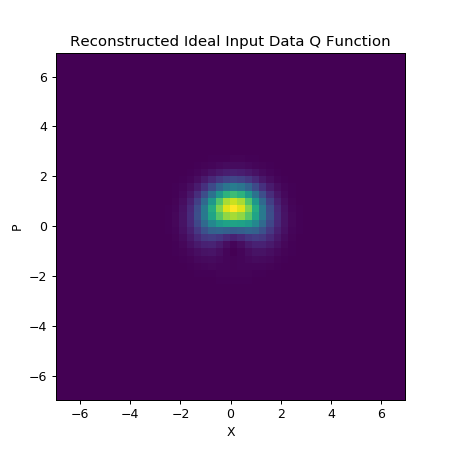

<IPython.core.display.Javascript object>


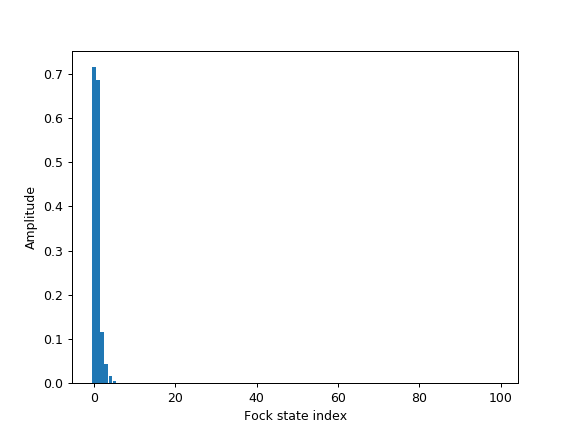

In [54]:
cst2.plot_coherent_state_tomography_Q_functions(data_histogram,
                                               reconstructed_signal_state,
                                               scaled_xs,
                                               scaled_ps)

<IPython.core.display.Javascript object>


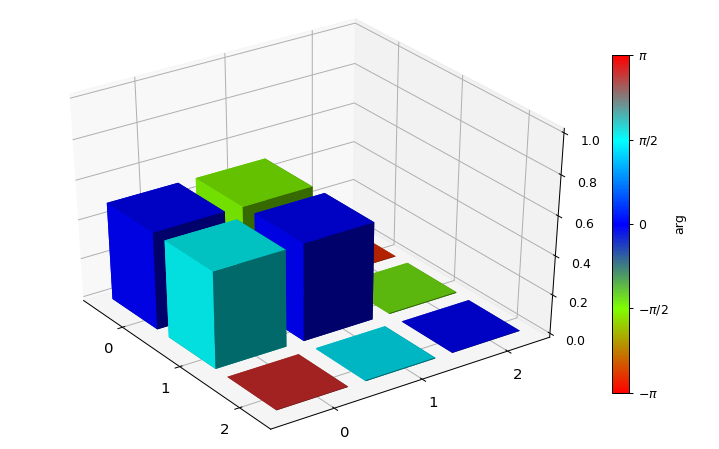

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[ 0.49779033+0.j         -0.00060343-0.49626805j -0.00184782-0.00054416j]
 [-0.00060343+0.49626805j  0.50042583+0.j          0.00051224-0.00441561j]
 [-0.00184782+0.00054416j  0.00051224+0.00441561j  0.0016192 +0.j        ]]

In [68]:
# Check first 3x3 block of the reconstructed density matrix
lower_cutoff = 0
upper_cutoff = 2
windowed_reconstructed_signal_state = state_vis.windowed_density_matrix(reconstructed_signal_state7,
                                                                        lower_cutoff,
                                                                        upper_cutoff)
fig, ax = state_vis.plot_density_matrix(windowed_reconstructed_signal_state)
qutip.Qobj(windowed_reconstructed_signal_state)